In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo
import nengo_ocl

The residual layer needs a neuron that doesn't do anything at all.  This isn't built in to Nengo, so we'll have to create it.  Since this is pretty much the same as the RectifiedLinear model, but without the rectification, we just subclass that neuron model.

In [2]:
class Linear(nengo.RectifiedLinear):
    def step(self, dt, J, output):
        output[...] = J

But, we also want this to work in `nengo_ocl`.  So, we need to define the OpenCL code that will run this neuron.  The actual C code is below -- it's just `outR = J;` and the rest is the boiler-plate code needed to make it all compile right.

In [3]:
from nengo_ocl.utils import as_ascii
from mako.template import Template   
from nengo_ocl.clra_nonlinearities import _plan_template

def plan_linear(queue, J, outR, **kwargs):
    inputs = dict(J=J)
    outputs = dict(outR=outR)
    parameters = dict()
    textconf = dict(type=J.ctype)

    decs = """
        """
    text = """
        outR = J;
        """
    decs = as_ascii(Template(decs, output_encoding='ascii').render(**textconf))
    text = as_ascii(Template(text, output_encoding='ascii').render(**textconf))
    cl_name = "cl_linear"
    return _plan_template(
        queue, cl_name, text, declares=decs,
        inputs=inputs, outputs=outputs, parameters=parameters, **kwargs)    


Now we make a new neuron model: the (non-spiking) leaky integrator.  We base this on the existing LIF model (since it already has a voltage as an internal state variable).

In [4]:
class LeakyIntegrator(nengo.LIF):
    threshold = nengo.params.NumberParam('threshold')
    
    def __init__(self, threshold=0, tau_rc=0.02):
        super().__init__(tau_rc=tau_rc, tau_ref=0)
        self.threshold = threshold
        
    def step(self, dt, J, output, voltage, refractory_time):
        # to map to the paper: output is y, voltage is u, and J is the inputs times the dictionary matrix
        
        # y = T(u)
        output[:] = np.where(voltage>self.threshold, voltage-self.threshold, 0)
        
        # du/dt = -u + y + phi*r
        dv = -voltage + output + J
        
        # perform the voltage update
        voltage += dv*(dt/self.tau_rc)

Again, we need to implement an OCL version of this as well

In [5]:
def plan_leaky_integrator(queue, dt, J, V, outR, thresh, inv_tau, amp, **kwargs):
    assert J.ctype == 'float'
    for x in [V, outR]:
        assert x.ctype == J.ctype

    inputs = dict(J=J, V=V)
    outputs = dict(outV=V, outR=outR)
    parameters = dict(inv_tau=inv_tau, thresh=thresh, amp=amp)
    textconf = dict(type=J.ctype, dt=dt)

    decs = """
        const ${type} dt = ${dt};
        """
    text = """
        if (V>thresh)
            outR = V-thresh;
        else
            outR = 0;
        V += (-V+outR+J)*(dt * inv_tau);
        outV = V;
        """
    decs = as_ascii(Template(decs, output_encoding='ascii').render(**textconf))
    text = as_ascii(Template(text, output_encoding='ascii').render(**textconf))
    cl_name = "cl_leaky_integrator"
    return _plan_template(
        queue, cl_name, text, declares=decs,
        inputs=inputs, outputs=outputs, parameters=parameters, **kwargs)    


For the V1->Residual connection, we need a Hebbian learning rule, and for the Residual->V1 connection we need the same rule with a flipped sign on the learning rate.  Since we also want to explore decaying connection weights and other tricks like that, here we define a full learning rule from scratch, implementing it in both `nengo` and `nengo_ocl`.

In [6]:
class HebbianWithDecay(nengo.learning_rules.LearningRuleType):
    modifies = 'weights'
    probeable = ('pre_filtered', 'post_filtered', 'delta')
    
    learning_rate = nengo.params.NumberParam('learning_rate')
    pre_synapse = nengo.synapses.SynapseParam('pre_synapse')
    post_synapse = nengo.synapses.SynapseParam('post_synapse')

    def __init__(self,
                 learning_rate=1e-6, 
                 pre_synapse=None,
                 post_synapse=None,
                 decay=0.0
                ):
        super().__init__(learning_rate, size_in=0)
        self.decay = decay
        self.pre_synapse = pre_synapse
        self.post_synapse = post_synapse
        
from nengo.builder.learning_rules import get_pre_ens, get_post_ens, build_or_passthrough

class SimHebbianWithDecay(nengo.builder.Operator):
    def __init__(self, pre_filtered, post_filtered, weights, delta,
                 learning_rate, decay, tag=None):
        super().__init__(tag=tag)
        self.learning_rate = learning_rate
        self.decay = decay

        self.sets = []
        self.incs = []
        self.reads = [pre_filtered, post_filtered, weights]
        self.updates = [delta]

    @property
    def delta(self):
        return self.updates[0]

    @property
    def pre_filtered(self):
        return self.reads[0]

    @property
    def post_filtered(self):
        return self.reads[1]

    @property
    def weights(self):
        return self.reads[2]

    def _descstr(self):
        return 'pre=%s, post=%s -> %s' % (
            self.pre_filtered, self.post_filtered, self.delta)

    def make_step(self, signals, dt, rng):
        weights = signals[self.weights]
        pre_filtered = signals[self.pre_filtered]
        post_filtered = signals[self.post_filtered]
        delta = signals[self.delta]
        alpha = self.learning_rate * dt
        decay = self.decay

        def step_simheb():
            # perform forgetting
            delta[...] = -decay * weights

            # perform update
            delta[...] += np.outer(alpha * post_filtered, pre_filtered)

        return step_simheb   


@nengo.builder.Builder.register(HebbianWithDecay)
def build_hebbian_decay(model, heb, rule):
    conn = rule.connection
    pre_activities = model.sig[get_pre_ens(conn).neurons]['out']
    post_activities = model.sig[get_post_ens(conn).neurons]['out']
    pre_filtered = build_or_passthrough(model, heb.pre_synapse, pre_activities)
    post_filtered = build_or_passthrough(model, heb.post_synapse, post_activities)

    model.add_op(SimHebbianWithDecay(pre_filtered,
                        post_filtered,
                        model.sig[conn]['weights'],
                        model.sig[rule]['delta'],
                        learning_rate=heb.learning_rate,
                        decay=heb.decay))

    # expose these for probes
    model.sig[rule]['pre_filtered'] = pre_filtered
    model.sig[rule]['post_filtered'] = post_filtered
    
    
# And now the nengo_ocl version    
import pyopencl as cl    
from nengo_ocl.plan import Plan
def plan_hebbian_with_decay(queue, pre, post, weights, delta, alpha, decay, tag=None):
    assert (len(pre) == len(post) == len(weights) == len(delta) ==
            alpha.size == decay.size)
    N = len(pre)

    for arr in (pre, post):  # vectors
        assert (arr.shape1s == 1).all()
    for arr in (delta, weights):  # matrices
        assert (arr.stride1s == 1).all()

    assert (post.shape0s == weights.shape0s).all()
    assert (pre.shape0s == weights.shape1s).all()
    assert (weights.shape0s == delta.shape0s).all()
    assert (weights.shape1s == delta.shape1s).all()

    assert (pre.ctype == post.ctype == weights.ctype == delta.ctype ==
            alpha.ctype == decay.ctype)

    text = """
    __kernel void heb(
        __global const int *shape0s,
        __global const int *shape1s,
        __global const int *pre_stride0s,
        __global const int *pre_starts,
        __global const ${type} *pre_data,
        __global const int *post_stride0s,
        __global const int *post_starts,
        __global const ${type} *post_data,
        __global const int *weights_stride0s,
        __global const int *weights_starts,
        __global const ${type} *weights_data,
        __global const int *delta_stride0s,
        __global const int *delta_starts,
        __global ${type} *delta_data,
        __global const ${type} *alphas,
        __global const ${type} *decays
    )
    {
        const int ij = get_global_id(0);
        const int k = get_global_id(1);
        const int shape0 = shape0s[k];
        const int shape1 = shape1s[k];
        const int i = ij / shape1;
        const int j = ij % shape1;
        __global ${type} *delta = delta_data + delta_starts[k];
        const ${type} pre = pre_data[pre_starts[k] + j*pre_stride0s[k]];
        const ${type} post = post_data[post_starts[k] + i*post_stride0s[k]];
        const ${type} weight = weights_data[
            weights_starts[k] + i*weights_stride0s[k] + j];
        const ${type} alpha = alphas[k];
        const ${type} decay = decays[k];
        if (i < shape0) {
            delta[i*delta_stride0s[k] + j] =
                alpha * post * pre - decay * weight;
        }
    }
    """

    textconf = dict(type=pre.ctype)
    text = as_ascii(Template(text, output_encoding='ascii').render(**textconf))

    full_args = (
        delta.cl_shape0s, delta.cl_shape1s,
        pre.cl_stride0s, pre.cl_starts, pre.cl_buf,
        post.cl_stride0s, post.cl_starts, post.cl_buf,
        weights.cl_stride0s, weights.cl_starts, weights.cl_buf,
        delta.cl_stride0s, delta.cl_starts, delta.cl_buf,
        alpha, decay,
    )
    _fn = cl.Program(queue.context, text).build().heb
    _fn.set_args(*[arr.data for arr in full_args])

    lsize = None
    gsize = (delta.sizes.max(), N)
    plan = Plan(queue, _fn, gsize, lsize=lsize, name="cl_heb", tag=tag)
    plan.full_args = full_args     # prevent garbage-collection
    plan.flops_per_call = 6 * delta.sizes.sum()
    plan.bw_per_call = (pre.nbytes + post.nbytes + weights.nbytes +
                        delta.nbytes + alpha.nbytes + decay.nbytes)
    return plan    

Now we build our model.  We have three basic "layers":  the image, the residual, and v1

In [26]:
seed = 10
np.random.seed(seed=seed)

N = 1000    # size of the input
J = 5000    # number of neurons

# generate an example image
span = np.linspace(0, 1, N)
image = (np.sin(2*np.pi*span)+1)/2

model = nengo.Network(seed=seed)
with model:
    # the input, which will be N-dimensional 
    #  (note that we can replace this with input that changes over time to give a more real-world example)
    stim = nengo.Node(image)
    
    # for the residual, we use N neurons which are ReLU neurons with a threshold of -infinity.  That is, 
    # there is no nonlinearity here at all.
    residual = nengo.Ensemble(n_neurons=N, dimensions=1,
                          neuron_type=Linear(),
                          gain=nengo.dists.Choice([1]),
                          bias=nengo.dists.Choice([0]))
    
    v1 = nengo.Ensemble(n_neurons=J, dimensions=1,
                          neuron_type=LeakyIntegrator(threshold=0.1, tau_rc=0.002),
                          gain=nengo.dists.Choice([1]),
                          bias=nengo.dists.Choice([0]))

    # the initial dictionary
    w = np.random.uniform(-0.01, 0.01, (J, N))
    
    # now we make the learning connections.
    learning_rate=1e-2
        
    tau = 0        # low-pass filter to use when using the w matrix
    tau_learn = 0  # low-pass filter to use when computing the Hebbian update
        
    c1 = nengo.Connection(residual.neurons, v1.neurons, transform=w, synapse=tau,
                     learning_rule_type=HebbianWithDecay(decay=0, pre_synapse=tau_learn, post_synapse=tau_learn, learning_rate=learning_rate))
        
    c2 = nengo.Connection(v1.neurons, residual.neurons, transform=-w.T, synapse=tau,
                     learning_rule_type=HebbianWithDecay(decay=0, pre_synapse=tau_learn, post_synapse=tau_learn, learning_rate=-learning_rate))
    
    # subtract the reconstruction from the stim to get the residual layer
    nengo.Connection(stim, residual.neurons, synapse=0)
    
    # record data from each layer, but only every 10ms just to keep the size of the matrices down
    p_v1 = nengo.Probe(v1.neurons, sample_every=0.01)
    p_res = nengo.Probe(residual.neurons, sample_every=0.01)
    p_c1 = nengo.Probe(c1, 'weights', sample_every=0.01)
    
    
    
                        

Let's run it in normal nengo

In [8]:
sim = nengo.Simulator(model)
with sim:
    sim.run(0.1)

c:\users\terry\git\nengo\nengo\neurons.py:578: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Now let's run it with `nengo_ocl`.  To do this, we need to tell `nengo_ocl` about the new neuron models we've defined.  We do that by subclassing `nengo_ocl.Simulator` and adding in some code that grabs data out of the nengo objects and feeds it into the code we defined above.

In [27]:

class LCASimulator(nengo_ocl.Simulator):
    def _plan_LeakyIntegrator(self, ops):
        dt = self.model.dt
        J = self.all_data[[self.sidx[op.J] for op in ops]]
        V = self.all_data[[self.sidx[op.state["voltage"]] for op in ops]]
        R = self.all_data[[self.sidx[op.output] for op in ops]]
        thresh = self.RaggedArray([op.neurons.threshold * np.ones(op.J.size)
                                   for op in ops], dtype=J.dtype)
        inv_tau = self.RaggedArray([(1/op.neurons.tau_rc) * np.ones(op.J.size)
                                for op in ops], dtype=J.dtype)
        amp = self.RaggedArray([op.neurons.amplitude * np.ones(op.J.size)
                                for op in ops], dtype=J.dtype)
        return [plan_leaky_integrator(self.queue, dt, J, V, R, thresh, inv_tau, amp)]
    def _plan_Linear(self, ops):
        J = self.all_data[[self.sidx[op.J] for op in ops]]
        R = self.all_data[[self.sidx[op.output] for op in ops]]
        return [plan_linear(self.queue, J, R)]
    
    def _plan_SimHebbianWithDecay(self, ops):
        pre = self.all_data[[self.sidx[op.pre_filtered] for op in ops]]
        post = self.all_data[[self.sidx[op.post_filtered] for op in ops]]
        weights = self.all_data[[self.sidx[op.weights] for op in ops]]
        delta = self.all_data[[self.sidx[op.delta] for op in ops]]
        alpha = self.Array([op.learning_rate * self.model.dt for op in ops])
        decay = self.Array([op.decay for op in ops])
        return [plan_hebbian_with_decay(self.queue, pre, post, weights, delta, alpha, decay)]

        
    
sim = LCASimulator(model)
with sim:
    sim.run(2)


c:\users\terry\git\nengo-ocl\nengo_ocl\simulator.py:202: UserWarning: This version of `nengo_ocl` has not been tested with your `nengo` version (3.2.0.dev0). The latest fully supported version is 3.1.0
  warnings.warn(
c:\users\terry\git\nengo\nengo\neurons.py:578: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Well that's a lot faster.  :)



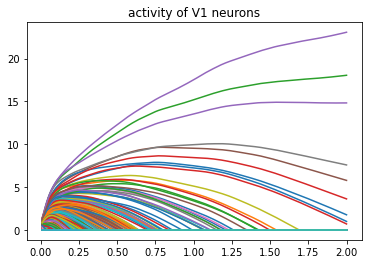

In [28]:
plt.plot(sim.trange(dt=0.01), sim.data[p_v1])
plt.title('activity of V1 neurons')
plt.show()

Now what does the reconstruction look like?

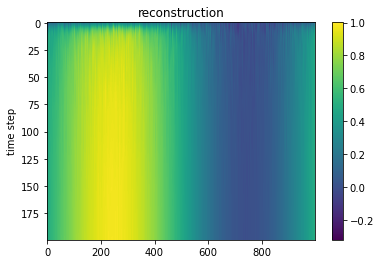

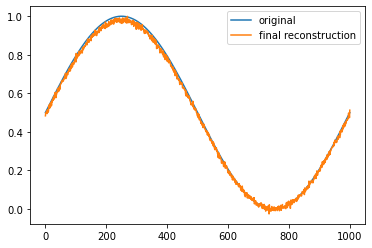

In [29]:
w = sim.data[p_c1]    # the weight matrix at each point in time
v1 = sim.data[p_v1]   # the activity of V1 over time



recon = np.zeros((w.shape[0], w.shape[2]))
for i in range(w.shape[0]):
    recon[i] = np.dot(v1[i], w[i])
# TODO: figure out a nicer way to do the above math in numpy    
    
plt.imshow(recon, aspect='auto')
plt.ylabel('time step')
plt.title('reconstruction')
plt.colorbar()
plt.figure()
plt.plot(image, label='original')
plt.plot(recon[-1], label='final reconstruction')
plt.legend()
plt.show()

And here's the residual layer

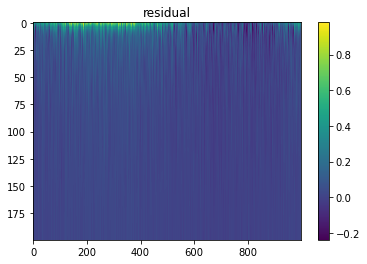

In [30]:
plt.imshow(sim.data[p_res][:,:], aspect='auto', interpolation='nearest')
plt.title('residual')
plt.colorbar()


And the activity of the V1 layer (to show it's sparse)

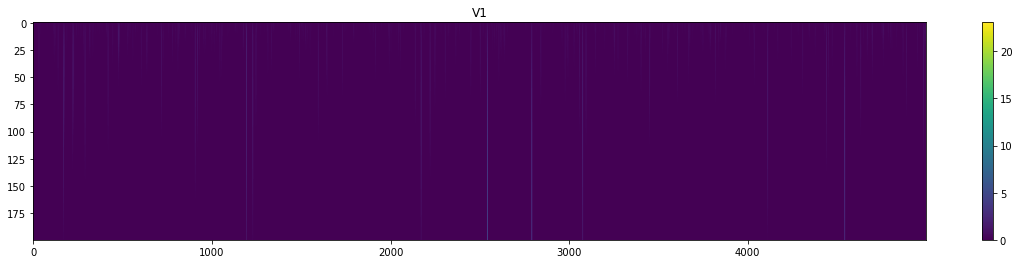

In [31]:
plt.figure(figsize=(20,4))
plt.imshow(sim.data[p_v1], aspect='auto', interpolation='bilinear')
plt.colorbar()
plt.title('V1')
plt.show()

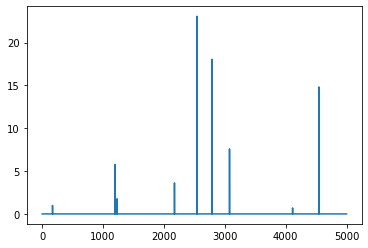

In [32]:
plt.plot(sim.data[p_v1][-1,:])